In [1]:
#analysis boilerplate imports
import fnal_column_analysis_tools
from fnal_column_analysis_tools.lookup_tools import extractor,evaluator
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from fnal_column_analysis_tools.striped import PhysicalColumnGroup,ColumnGroup,jaggedFromColumnGroup

import numpy as np
from awkward import JaggedArray,Table
import uproot
import time
from tqdm import tqdm

In [2]:
#histogram display boilerplate
from histbook import Hist, beside, groupby, below
from histbook import bin as hbin
from collections import OrderedDict
from striped.job import SinglePointStripedSession as Session, IPythonDisplay
import histbook as hb
import math

all_hists = OrderedDict()
cat = hb.groupby("category", keeporder=True)

def add_1d(*args):
    h = hb.Hist(hb.bin(*args), cat)
    all_hists[args[0]] = h
    return h

display_opts = {'width': 200, 'height': 200}
def buildDisplay(hists, cols=3):
    rows = []
    for iRow in range(int(math.ceil(len(hists)/cols))+1):
        hrowname = hists.keys()[iRow*cols:(iRow+1)*cols]
        hrow = hists.values()[iRow*cols:(iRow+1)*cols]
        rows.append(hb.beside(*tuple(h.overlay("category").step(n, **display_opts) for h,n in zip(hrow, hrowname))))
    return IPythonDisplay(
        hb.below(*tuple(rows))
    )

In [3]:
#make and fill a histogram of the masses
add_1d("m_J", 150,50,200)#, weight="weight")
add_1d("pT_J", 300,200,800)#, weight="weight")
add_1d("deepDoubleB",50,0,1)
add_1d("tau21",50,0,1)
add_1d("tau32",50,0,1)

display = buildDisplay(all_hists,cols=3)

In [4]:
extract = extractor()
correction_data = open("dazsle_corr_files.txt").readlines()
extract.add_weight_sets(correction_data)
#define the weights we want to keep
keep_weights = ["Rho2D","ZJetsNLO","WJetsNLO",
                "PUWeight2016_central","PUWeight2016_up","PUWeight2016_down",
                "PUWeight2017_central","PUWeight2017_up","PUWeight2017_down",
                "data_obs_muCR4_denominator","data_obs_muCR4_numerator",
                "Mu50_PtEtaBins/efficienciesDATA/pt_abseta_DATA",
                "NUM_SoftID_DEN_genTracks/abseta_pt_value","NUM_SoftID_DEN_genTracks/abseta_pt_error",
                "NUM_LooseRelIso_DEN_LooseID/abseta_pt_value","NUM_LooseRelIso_DEN_LooseID/abseta_pt_error",
                "electron_id_EffArea",
                "photon_id_EA_CHad","photon_id_EA_NHad","photon_id_EA_Pho"]
extract.finalize(reduce_list=keep_weights)
#make the evaluator
evaluate = extract.make_evaluator()

In [5]:
#build a string of "OR" for list of triggers from json bits file
import json
def selectTriggers(imap,triggerMap):
    if not imap =={}:
        version     = imap['version']
        hltNames    = imap['names']
        branchName  = imap['branchName'] #triggerBits or moreTriggerBits
        #validate input
        if version in triggerMap:
            NameToBitMap = triggerMap[version]
        else:
            print "ERROR! Cannot find triggerbit map of the requested bit version =%s. Possible versions are: %s"%(version, ",".join(triggerMap.keys()))
        tCuts = []
        for hltName in hltNames:
            print hltName
            if hltName in NameToBitMap:
                bitValue = int(2**float(NameToBitMap[hltName]))
                tCuts.append("%s & %s"%(branchName,bitValue))
            else:
                print "ERROR! Cannot find the TriggerBit for %s"%hltName 
        print "Using trigger bits = ","||".join(tCuts) 
        return "||".join(tCuts) 
    else:
        return "1"

triggerBitMaps = json.load(open("ggH/TriggerBitMap.json"))

triggerNames = {} #???
triggerCut = selectTriggers(triggerNames,triggerBitMaps)
if not triggerNames=={}:
    print "List of OR Triggers : ",triggerNames['names']
    print "Using trigger cuts  : ",triggerCut

In [6]:
#trigger eff scale factors (todo: )
def VtrigSF(ak8msd,ak8pt):
    msd = ak8msd
    pt = ak8pt
    if isinstance(ak8msd,JaggedArray):
        assert (ak8msd.offsets==ak8pt.offsets).all()
        msd = ak8msd.flatten()
        pt = ak8pt.flatten()
    else:
        assert ak8msd.size == ak8pt.size
    msd = np.clip(msd,0,300)
    pt = np.clip(pt,200,1000)
    trig_num = evaluate['data_obs_muCR4_numerator'](msd,pt)
    trig_den = evaluate['data_obs_muCR4_denominator'](msd,pt)
    eff = trig_num/trig_den
    if isinstance(ak8msd,JaggedArray):
        eff = JaggedArray.fromoffsets(ak8pt.offsets,eff)
    return eff

In [7]:
#WJetsQQ and ZJetsQQ kfactors
def VJetsQQ_kFactor(sampleName,lookup,genVPt):
    kfactor = genVPt.ones_like()
    if 'ZJetsToQQ_' in sampleName:
        kfactor = lookup['ZJetsNLO'](np.clip(genVPt,250.,1200.))
    elif 'WJetsToQQ_' in sampleName:
        kfactor = lookup['WJetsNLO'](np.clip(genVPt,250.,1200.))
    return kfactor

In [8]:
#PUPPI soft-drop mass correction
def corrGEN(pt):
    #self.corrGEN = ROOT.TF1("corrGEN", "[0]+[1]*pow(x*[2],-[3])", 200, 3500)
    #self.corrGEN.SetParameter(0, 1.00626)
    #self.corrGEN.SetParameter(1, -1.06161)
    #self.corrGEN.SetParameter(2, 0.0799900)
    #self.corrGEN.SetParameter(3, 1.20454)
    x = np.clip(pt,200,3500)
    return 1.00626 - 1.06161*pow(x*0.0799900,-1.20454)

def corrRECO_cen(pt):    
    x = np.clip(pt,200,3500)
    return 1.09302 + x*(-0.000150068+x*(3.44866e-07+x*(-2.68100e-10+x*(8.67440e-14+ x*(-1.00114e-17)))))

def corrRECO_for(pt):  
    x = np.clip(pt,200,3500)
    return 1.27212 + x*(-0.000571640+x*(8.37289e-07+x*(-5.20433e-10+x*(1.45375e-13+ x*(-1.50389e-17)))))

def PUPPIweight(ak8pt,ak8eta):
    pt = ak8pt
    eta = ak8eta
    if isinstance(ak8pt,JaggedArray):
        assert (ak8pt.offsets==ak8eta.offsets).all()
        pt = ak8pt.flatten()
        eta = ak8eta.flatten()
    else:
        assert ak8pt.size == ak8eta.size
        
    genCorr = corrGEN(pt)
    recoCorr = np.ones_like(eta)
    
    etaCut = np.abs(eta) < 1.3
    recoCorr[etaCut] = corrRECO_cen(pt[etaCut])
    recoCorr[~etaCut] = corrRECO_for(pt[~etaCut])
    
    total = genCorr*recoCorr
    
    if isinstance(ak8pt,JaggedArray):
        total = JaggedArray.fromoffsets(ak8pt.offsets,total)
    
    return total

In [9]:
#muon IDs
kPOGLooseMuon  =  1 << 0
kPOGMediumMuon =  1 << 1
kPOGTightMuon  =  1 << 2
kPOGSoftMuon   =  1 << 3
kPOGHighPtMuon =  1 << 4

def calcMuonDeltaBetaIso(muon):
    return muon.chHadIso + np.maximum(muon.neuHadIso + muon.gammaIso - 0.5*(muon.puIso), 0.0)

def passMuonLooseSel(muon):
    return (((muons.pogIDBits & kPOGLooseMuon) > 0) & (muon.deltaBetaIso < 0.25*muon.pt))

def passMuonMediumSel(muon):
    return (((muons.pogIDBits & kPOGMediumMuon) > 0) & (muon.deltaBetaIso < 0.25*muon.pt))

def passMuonTightSel(muon):
    return (((muons.pogIDBits & kPOGTightMuon) > 0) & (muon.deltaBetaIso < 0.25*muon.pt))

def passHighPtMuonSel(muon):
    return (((muons.pogIDBits & kPOGHighPtMuon) > 0) & (muon.deltaBetaIso < 0.25*muon.pt))

In [10]:
#electron IDs
kEcalDriven    = 1 << 0
kTrackerDriven = 1 << 1

def calcElectronEffAreaIso(electron,rho):
    return electron.chHadIso + np.maximum(0.0, (electron.gammaIso + electron.neuHadIso - rho.content*electron.EffArea) )
    
def passEleVetoSel(electron):
    outs = (electron.isConv.content == 0)
    etaCut = (np.abs(electron.scEta.content) < 1.479)    
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( ( electron.effAreaIso.content[etaCut] < 
                                      0.175*electron.pt.content[etaCut]      ) &
                      ( electron.sieie.content[etaCut] < 0.01150             ) & 
                      ( np.abs(electron.dEtaInSeed.content[etaCut]) < 0.00749) &
                      ( np.abs(electron.dPhiIn.content[etaCut]) < 0.22800    ) &
                      ( electron.hovere.content[etaCut] < 0.35600            ) &
                      ( np.abs(1.0 - electron.eoverp.content[etaCut]) < 
                               0.29900*electron.ecalEnergy.content[etaCut]   ) &
                      ( electron.nMissingHits.content[etaCut] <= 2           )   )
    #endcap
    outs[notEta] &= ( ( electron.effAreaIso.content[notEta] < 
                                      0.159*electron.pt.content[notEta]      ) &
                      ( electron.sieie.content[notEta] < 0.03700             ) & 
                      ( np.abs(electron.dEtaInSeed.content[notEta]) < 0.00895) &
                      ( np.abs(electron.dPhiIn.content[notEta]) < 0.21300    ) &
                      ( electron.hovere.content[notEta] < 0.21100            ) &
                      ( np.abs(1.0 - electron.eoverp.content[notEta]) < 
                               0.15000*electron.ecalEnergy.content[notEta]   ) &
                      ( electron.nMissingHits.content[notEta] <= 3           )   )
    outs = JaggedArray.fromoffsets(electron.pt.offsets,outs)    
    return outs

def passEleLooseSel(electron):
    outs = (electron.isConv.content == 0)
    etaCut = (np.abs(electron.scEta.content) < 1.479)    
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( ( electron.effAreaIso.content[etaCut] < 
                                      0.0994*electron.pt.content[etaCut]     ) &
                      ( electron.sieie.content[etaCut] < 0.01100             ) & 
                      ( np.abs(electron.dEtaInSeed.content[etaCut]) < 0.00477) &
                      ( np.abs(electron.dPhiIn.content[etaCut]) < 0.22200    ) &
                      ( electron.hovere.content[etaCut] < 0.29800            ) &
                      ( np.abs(1.0 - electron.eoverp.content[etaCut]) < 
                               0.24100*electron.ecalEnergy.content[etaCut]   ) &
                      ( electron.nMissingHits.content[etaCut] <= 1           )   )
    #endcap
    outs[notEta] &= ( ( electron.effAreaIso.content[notEta] < 
                                      0.107*electron.pt.content[notEta]      ) &
                      ( electron.sieie.content[notEta] < 0.03700             ) & 
                      ( np.abs(electron.dEtaInSeed.content[notEta]) < 0.00895) &
                      ( np.abs(electron.dPhiIn.content[notEta]) < 0.21300    ) &
                      ( electron.hovere.content[notEta] < 0.10100            ) &
                      ( np.abs(1.0 - electron.eoverp.content[notEta]) < 
                               0.14000*electron.ecalEnergy.content[notEta]   ) &
                      ( electron.nMissingHits.content[notEta] <= 1           )   )
    outs = JaggedArray.fromoffsets(electron.pt.offsets,outs)
    return outs

def passEleMediumSel(electron):
    outs = (electron.isConv.content == 0)
    etaCut = (np.abs(electron.scEta.content) < 1.479)    
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( ( electron.effAreaIso.content[etaCut] < 
                                      0.0695*electron.pt.content[etaCut]     ) &
                      ( electron.sieie.content[etaCut] < 0.00998             ) & 
                      ( np.abs(electron.dEtaInSeed.content[etaCut]) < 0.00311) &
                      ( np.abs(electron.dPhiIn.content[etaCut]) < 0.10300    ) &
                      ( electron.hovere.content[etaCut] < 0.25300            ) &
                      ( np.abs(1.0 - electron.eoverp.content[etaCut]) < 
                               0.13400*electron.ecalEnergy.content[etaCut]   ) &
                      ( electron.nMissingHits.content[etaCut] <= 1           )   )
    #endcap
    outs[notEta] &= ( ( electron.effAreaIso.content[notEta] < 
                                      0.0821*electron.pt.content[notEta]     ) &
                      ( electron.sieie.content[notEta] < 0.02980             ) & 
                      ( np.abs(electron.dEtaInSeed.content[notEta]) < 0.00609) &
                      ( np.abs(electron.dPhiIn.content[notEta]) < 0.04500    ) &
                      ( electron.hovere.content[notEta] < 0.08780            ) &
                      ( np.abs(1.0 - electron.eoverp.content[notEta]) < 
                               0.13000*electron.ecalEnergy.content[notEta]   ) &
                      ( electron.nMissingHits.content[notEta] <= 1           )   )
    outs = JaggedArray.fromoffsets(electron.pt.offsets,outs)
    return outs

def passEleTightSel(electron):
    outs = (electron.isConv.content == 0)
    etaCut = (np.abs(electron.scEta.content) < 1.479)    
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( ( electron.effAreaIso.content[etaCut] < 
                                      0.0588*electron.pt.content[etaCut]     ) &
                      ( electron.sieie.content[etaCut] < 0.00998             ) & 
                      ( np.abs(electron.dEtaInSeed.content[etaCut]) < 0.00308) &
                      ( np.abs(electron.dPhiIn.content[etaCut]) < 0.08160    ) &
                      ( electron.hovere.content[etaCut] < 0.04140            ) &
                      ( np.abs(1.0 - electron.eoverp.content[etaCut]) < 
                               0.12900*electron.ecalEnergy.content[etaCut]   ) &
                      ( electron.nMissingHits.content[etaCut] <= 1           )   )
    #endcap
    outs[notEta] &= ( ( electron.effAreaIso.content[notEta] < 
                                      0.0571*electron.pt.content[notEta]     ) &
                      ( electron.sieie.content[notEta] < 0.02920             ) & 
                      ( np.abs(electron.dEtaInSeed.content[notEta]) < 0.00605) &
                      ( np.abs(electron.dPhiIn.content[notEta]) < 0.03940    ) &
                      ( electron.hovere.content[notEta] < 0.06410            ) &
                      ( np.abs(1.0 - electron.eoverp.content[notEta]) < 
                               0.12900*electron.ecalEnergy.content[notEta]   ) &
                      ( electron.nMissingHits.content[notEta] <= 1           )   )
    outs = JaggedArray.fromoffsets(electron.pt.offsets,outs)
    return outs

def passEleHEEPSel(electron,rho,met):
    outs = ( (electron.typeBits.content & kEcalDriven) > 0 )
    outs &= (met <= 35)
    absSCEta = np.abs(electron.scEta.content)
    etaBar = (absSCEta < 1.442)    
    etaEnd = ( (absSCEta > 1.566) & (absSCEta < 2.5) )
    notEta = ~(etaBar | etaEnd)
    outs[notEta] = False #anything in the gap dies
    # setup all the hcalDepth1Iso cuts    
    ones = electron.typeBits.ones_like()
    hcalDepth1Cuts = np.zeros_like(ones.content)
    mets = (met.content*ones).content
    rhos = (rho.content*ones).content
    hcalDepth1Cuts[etaBar] = 2.0+0.03*mets[etaBar]+0.28*rhos[etaBar]
    hcalDepth1Cuts[etaEnd & (mets < 50)] = 2.5+0.28*rhos[etaEnd & (mets < 50)]
    hcalDepth1Cuts[etaEnd & (mets >= 50)] = ( 2.5 + 0.03*(mets[etaEnd & (mets >= 50)]-50) + 
                                              0.28*rhos[etaEnd & (mets >= 50)] )
    
    #barrel
    outs[etaBar] &= ( ( np.abs(electron.dEtaInSeed.content[etaBar]) < 0.00600) &
                      ( np.abs(electron.dPhiIn.content[etaBar]) < 0.06000    ) &
                      ( electron.hovere.content[etaBar] < 
                           (1.0/(electron.ecalEnergy.content[etaBar])+0.05)  ) &
                      (electron.e2x5.content[etaBar]/
                            electron.e5x5.content[etaBar] > 0.94             ) &
                      (electron.e1x5.content[etaBar]/
                            electron.e5x5.content[etaBar] > 0.83             ) &
                      ( electron.hcalDepth1Iso.content[etaBar] < 
                                     hcalDepth1Cuts[etaBar]                  ) & 
                      ( electron.trkIso.content[etaBar] < 5                  ) &
                      ( electron.nMissingHits.content[etaBar] <= 1           ) &
                      ( electron.d0.content[etaBar] <= 0.02                  )   )
    #endcap
    outs[etaEnd] &= ( ( np.abs(electron.dEtaInSeed.content[etaEnd]) < 0.00400) &
                      ( np.abs(electron.dPhiIn.content[etaEnd]) < 0.06000    ) &
                      ( electron.hovere.content[etaEnd] < 
                           (5.0/(electron.ecalEnergy.content[etaEnd])+0.05)  ) &
                      (electron.sieie.content[etaEnd] < 0.03                 ) &                      
                      ( electron.hcalDepth1Iso.content[etaEnd] < 
                                     hcalDepth1Cuts[etaEnd]                  ) & 
                      ( electron.trkIso.content[etaEnd] < 5                  ) &
                      ( electron.nMissingHits.content[etaEnd] <= 1           ) &
                      ( electron.d0.content[etaEnd] <= 0.05                  )   )
    outs = JaggedArray.fromoffsets(electron.pt.offsets,outs)
    return outs


In [11]:
#tau IDs
# descriptions from https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuidePFTauID#Discriminators
kByDecayModeFinding                        = 1 << 0   # You will always want to use this (see AN-10-82) 

kByVLooseIsolation                         = 1 << 1   # isolation cone of 0.3, no PF Charged Candidates with pT > 1.5 GeV/c and no PF Gamma candidates with ET > 2.0 GeV
kByLooseIsolation                          = 1 << 2   # (description N/A)
kByMediumIsolation                         = 1 << 3   # (description N/A)
kByTightIsolation                          = 1 << 4   # (description N/A)
kByVLooseIsolationDBSumPtCorr              = 1 << 5   # (description N/A)
kByLooseIsolationDBSumPtCorr               = 1 << 6   # (description N/A)
kByMediumIsolationDBSumPtCorr              = 1 << 7   # (description N/A)
kByTightIsolationDBSumPtCorr               = 1 << 8   # (description N/A)
kByVLooseCombinedIsolationDBSumPtCorr      = 1 << 9   # isolation cone of 0.3, Delta Beta corrected sum pT of PF charged and PF gamma isolation candidates (pT > 0.5 GeV) less than 3 GeV
kByLooseCombinedIsolationDBSumPtCorr       = 1 << 10  # isolation cone of 0.5, Delta Beta corrected sum pT of PF charged and PF gamma isolation candidates (pT > 0.5 GeV) less than 2 GeV
kByMediumCombinedIsolationDBSumPtCorr      = 1 << 11  # isolation cone of 0.5, Delta Beta corrected sum pT of PF charged and PF gamma isolation candidates (pT > 0.5 GeV) less than 1 GeV
kByTightCombinedIsolationDBSumPtCorr       = 1 << 12  # isolation cone of 0.5, Delta Beta corrected sum pT of PF charged and PF gamma isolation candidates (pT > 0.5 GeV) less than 0.8 GeV
kByLooseCombinedIsolationDBSumPtCorr3Hits  = 1 << 13  # same as ByLooseCombinedIsolationDBSumPtCorr but requiring 3 hits (instead of 8) on track of isolation candidates
kByMediumCombinedIsolationDBSumPtCorr3Hits = 1 << 14  # same as ByMediumCombinedIsolationDBSumPtCorr but requiring 3 hits (instead of 8) on track of isolation candidates
kByTightCombinedIsolationDBSumPtCorr3Hits  = 1 << 15  # same as ByTightCombinedIsolationDBSumPtCorr but requiring 3 hits (instead of 8) on track of isolation candidates
kByLooseIsolationMVA                       = 1 << 16  # BDT based selection using isolation in rings around tau direction and shower shape variables
kByMediumIsolationMVA                      = 1 << 17  #  "
kByTightIsolationMVA                       = 1 << 18  #  "
kByLooseIsolationMVA2                      = 1 << 19  # same as ByLooseIsolationMVA with new training and improved performance
kByMediumIsolationMVA2                     = 1 << 20  # same as ByMediumIsolationMVA with new training and improved performance
kByTightIsolationMVA2                      = 1 << 21  # same as ByTightIsolationMVA with new training and improved performance

kByLooseElectronRejection                  = 1 << 22  # electron pion MVA discriminator < 0.6
kByMediumElectronRejection                 = 1 << 23  # electron pion MVA discriminator < -0.1 and not 1.4442 < |eta| < 1.566
kByTightElectronRejection                  = 1 << 24  # electron pion MVA discriminator < -0.1 and not 1.4442 < |eta| < 1.566 and Brem pattern cuts (see AN-10-387)
kByMVA3LooseElectronRejection              = 1 << 25  # anti-electron MVA discriminator with improved training
kByMVA3MediumElectronRejection             = 1 << 26  #  "
kByMVA3TightElectronRejection              = 1 << 27  #  "
kByMVA3VTightElectronRejection             = 1 << 28  #  "
    
kByLooseMuonRejection                      = 1 << 29  # Tau Lead Track not matched to chamber hits
kByMediumMuonRejection                     = 1 << 30  # Tau Lead Track not matched to global/tracker muon
kByTightMuonRejection                      = 1 << 31  # Tau Lead Track not matched to global/tracker muon and large enough energy deposit in ECAL+HCAL exceeding 0.2 times Lead Track momentum
kByLooseMuonRejection2                     = 1 << 32  # Same as LooseMuonRejection
kByMediumMuonRejection2                    = 1 << 33  # LooseMuonRejection2 && no DT, CSC or RPC Hits in last 2 Stations
kByTightMuonRejection2                     = 1 << 34  # MediumMuonRejection2 && large enough energy deposit in ECAL+HCAL in 1 prong + 0 strip decay mode (SUM(ECAL+HCAL)>0.2*pT)
kByLooseMuonRejection3                     = 1 << 35  # Same as LooseMuonRejection
kByTightMuonRejection3                     = 1 << 36  # MediumMuonRejection2 && large enough energy deposit in ECAL+HCAL in 1 prong + 0 strip decay mode (SUM(ECAL+HCAL)>0.2*pT)

def passTauSel(tau):
    return ( ((tau.hpsDisc & kByDecayModeFinding) > 0) & (tau.rawIso3Hits < 5) )

In [12]:
#photon IDs

def calcPhotonEffAreaIso(photon,rho):
    chHadIso  = np.maximum(photon.chHadIso  - rho.content*photon.EA_CHad,0.);
    neuHadIso = np.maximum(photon.neuHadIso - rho.content*photon.EA_NHad,0.);
    phoIso    = np.maximum(photon.gammaIso  - rho.content*photon.EA_Pho, 0.);

    maxNeuHadLooseIso = np.zeros_like(photon.pt.content)
    maxNeuHadMediumIso = np.zeros_like(photon.pt.content)
    maxNeuHadTightIso = np.zeros_like(photon.pt.content)
    etaCut = (photon.absSCEta.content < 1.479)
    notEta = ~etaCut
    #common bits
    ptshape = np.zeros_like(photon.pt.content)
    ptshape[etaCut] = photon.pt.content[etaCut]*(0.0148+0.000017*photon.pt.content[etaCut])
    ptshape[notEta] = photon.pt.content[notEta]*(0.0163+0.000014*photon.pt.content[notEta])
    
    #loose
    maxNeuHadLooseIso[etaCut] = 10.910 + ptshape[etaCut]
    maxNeuHadLooseIso[notEta] = 5.931  + ptshape[notEta]
    maxNeuHadLooseIso = JaggedArray.fromoffsets(photon.pt.offsets,maxNeuHadLooseIso)
    
    #medium
    maxNeuHadMediumIso[etaCut] = 2.725 + ptshape[etaCut]
    maxNeuHadMediumIso[notEta] = 1.715 + ptshape[notEta]
    maxNeuHadMediumIso = JaggedArray.fromoffsets(photon.pt.offsets,maxNeuHadMediumIso)
    
    #tight
    maxNeuHadTightIso[etaCut] = 0.264 + ptshape[etaCut]
    maxNeuHadTightIso[notEta] = 0.586 + ptshape[notEta]   
    maxNeuHadTightIso = JaggedArray.fromoffsets(photon.pt.offsets,maxNeuHadTightIso)
    
    return chHadIso,neuHadIso,phoIso,maxNeuHadLooseIso,maxNeuHadMediumIso,maxNeuHadTightIso

def passPhoLooseSel(photon):
    outs = np.ones_like(photon.absSCEta.content,dtype=np.bool)
    etaCut = ( photon.absSCEta.content < 1.479 )
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( (photon.hovere.content[etaCut] <= 0.0597      ) &
                      (photon.sieie.content[etaCut] <= 0.01031      ) &
                      (photon.chIsoCorr.content[etaCut] <= 1.295    ) &
                      (photon.nhIsoCorr.content[etaCut] <= 
                                photon.neuIsoMax.content[etaCut]    ) &
                      (photon.gamIsoCorr.content[etaCut] <= 3.630 + 
                                   0.0047*photon.pt.content[etaCut] )   )
    #endcap
    outs[notEta] &= ( (photon.hovere.content[notEta] <= 0.0481      ) &
                      (photon.sieie.content[notEta] <= 0.03013      ) &
                      (photon.chIsoCorr.content[notEta] <= 1.011    ) &
                      (photon.nhIsoCorr.content[notEta] <= 
                            photon.neuIsoLooseMax.content[notEta]   ) &
                      (photon.gamIsoCorr.content[notEta] <= 6.641 + 
                                   0.0034*photon.pt.content[notEta] )   )
    outs = JaggedArray.fromoffsets(photon.pt.offsets,outs)
    return outs

def passPhoMediumSel(photon):
    outs = np.ones_like(photon.absSCEta.content,dtype=np.bool)
    etaCut = ( photon.absSCEta.content < 1.479 )
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( (photon.hovere.content[etaCut] <= 0.0396      ) &
                      (photon.sieie.content[etaCut] <= 0.01022      ) &
                      (photon.chIsoCorr.content[etaCut] <= 0.441    ) &
                      (photon.nhIsoCorr.content[etaCut] <= 
                                photon.neuIsoMax.content[etaCut]    ) &
                      (photon.gamIsoCorr.content[etaCut] <= 2.571 + 
                                   0.0047*photon.pt.content[etaCut] )   )
    #endcap
    outs[notEta] &= ( (photon.hovere.content[notEta] <= 0.0219      ) &
                      (photon.sieie.content[notEta] <= 0.03001      ) &
                      (photon.chIsoCorr.content[notEta] <= 0.442    ) &
                      (photon.nhIsoCorr.content[notEta] <= 
                            photon.neuIsoMediumMax.content[notEta]  ) &
                      (photon.gamIsoCorr.content[notEta] <= 3.863 + 
                                   0.0034*photon.pt.content[notEta] )   )
    outs = JaggedArray.fromoffsets(photon.pt.offsets,outs)
    return outs

def passPhoTightSel(photon):
    outs = np.ones_like(photon.absSCEta.content,dtype=np.bool)
    etaCut = ( photon.absSCEta.content < 1.479 )
    notEta = ~etaCut
    #barrel
    outs[etaCut] &= ( (photon.hovere.content[etaCut] <= 0.0269      ) &
                      (photon.sieie.content[etaCut] <= 0.00994      ) &
                      (photon.chIsoCorr.content[etaCut] <= 0.202    ) &
                      (photon.nhIsoCorr.content[etaCut] <= 
                                photon.neuIsoMax.content[etaCut]    ) &
                      (photon.gamIsoCorr.content[etaCut] <= 2.362 + 
                                   0.0047*photon.pt.content[etaCut] )   )
    #endcap
    outs[notEta] &= ( (photon.hovere.content[notEta] <= 0.0213      ) &
                      (photon.sieie.content[notEta] <= 0.03000      ) &
                      (photon.chIsoCorr.content[notEta] <= 0.034    ) &
                      (photon.nhIsoCorr.content[notEta] <= 
                            photon.neuIsoTightMax.content[notEta]   ) &
                      (photon.gamIsoCorr.content[notEta] <= 2.617 + 
                                   0.0034*photon.pt.content[notEta] )   )
    outs = JaggedArray.fromoffsets(photon.pt.offsets,outs)
    return outs

In [13]:
#btag working points

CSVv2_L_AK4 = 0.5426 # CSVv2 WP
CSVv2_M_AK4 = 0.8484
CSVv2_T_AK4 = 0.9535

CSVv2SubJet_L_AK8 = 0.5426; # CSVv2SubJet WP 
CSVv2SubJet_M_AK8 = 0.8484;

def CSV_Medium(jet,ptCut=50,absEtaCut=2.5):
    return ( (jet.pt > ptCut) & (np.abs(jet.eta) < absEtaCut) & (jet.csv > CSVv2_M_AK4) )


In [14]:
#jet selections
def passJetTightLepVetoSel(jet):
    outs = np.ones_like(jet.pt.content,dtype=np.bool)
    absEta = np.abs(jet.eta.content)
    etaFor = (absEta <= 2.7)
    etaCen = (absEta <= 2.4)
    #forward jets
    outs[etaFor] &= ( (jet.neuHadFrac.content[etaFor] < 0.90) &
                      (jet.neuEmFrac.content[etaFor]  < 0.90) &
                      (jet.nParticles.content[etaFor] > 1   ) &
                      (jet.muonFrac.content[etaFor]   < 0.8 )  )
    #central jets
    outs[etaCen] &= ( (jet.chHadFrac.content[etaCen]  > 0.0 ) &
                      (jet.nCharged.content[etaCen]   > 0   ) &
                      (jet.chEmFrac.content[etaCen]   < 0.9 )  )
    outs = JaggedArray.fromoffsets(jet.pt.offsets,outs)
    return outs


In [15]:
#matching functions
def argMatchByDPhi(combs,deltaPhiCut=2./3.*math.pi):
    deltaPhis = np.abs(combs.i0.delta_phi(combs.i1))
    indexOfMin = deltaPhis.argmin()
    indexOfMinOutShape = indexOfMin.flatten(axis=1)
    passesCut = (deltaPhis[indexOfMin] <= deltaPhiCut)
    passesCutOutShape = passesCut.flatten(axis=1)
    flatPass = passesCutOutShape.flatten()
    flatIdxMin = indexOfMinOutShape.flatten()
    flatIdxMin[~flatPass] = -1
    return JaggedArray.fromoffsets(passesCutOutShape.offsets,flatIdxMin)

def antiMatchByDR(combs,deltaRCut=0.8):
    mask = (combs.i0.delta_r(combs.i1) > deltaRCut)
    return mask.any()

In [16]:
#analysis cut defaults
PTCUT = 300.#450.
PTCUTMUCR = 250.#400.
#DBTAGCUT = 0.9
#DBTAGCUT = 0.86
#DBTAGCUT = 0.94
T21DDTCUT = 0.55
MUONPTCUT = 55
METCUT = 140
MASSCUT = 40
NJETCUT = 100

#self._cutFormula = ROOT.TTreeFormula("cutFormula",
#                                     "(" + cutFormula + ")&&("+self._triggerCut+")&&(AK8Puppijet0_pt>%f||AK8Puppijet0_pt_JESDown>%f||AK8Puppijet0_pt_JESUp>%f||AK8Puppijet0_pt_JERUp>%f||AK8Puppijet0_pt_JERDown>%f)" % (
#                                     PTCUTMUCR, PTCUTMUCR, PTCUTMUCR, PTCUTMUCR, PTCUTMUCR), self._tt)

In [17]:
from pyinstrument import Profiler

profiler = Profiler()



extracting 103 columns


/anaconda2/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: overflow encountered in sinh
  z = pt * awkward.util.numpy.sinh(eta)
/anaconda2/lib/python2.7/site-packages/uproot_methods/classes/TLorentzVector.py:614: RuntimeWarning: invalid value encountered in multiply
  z = pt * awkward.util.numpy.sinh(eta)


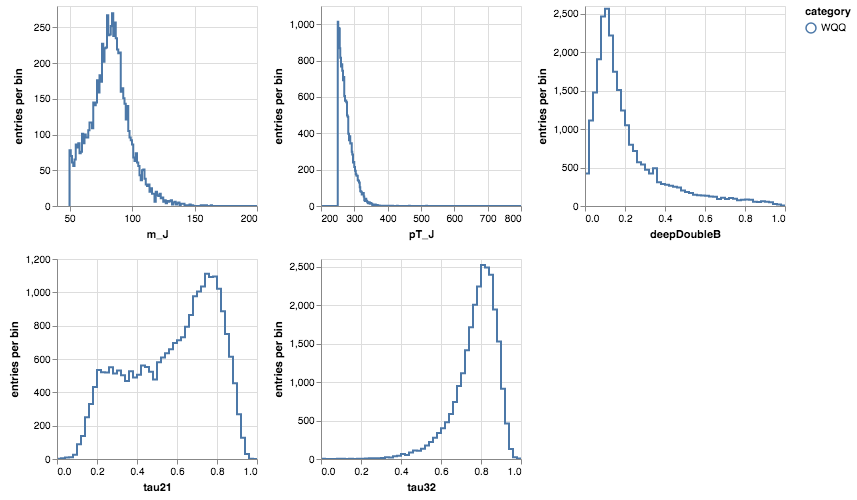

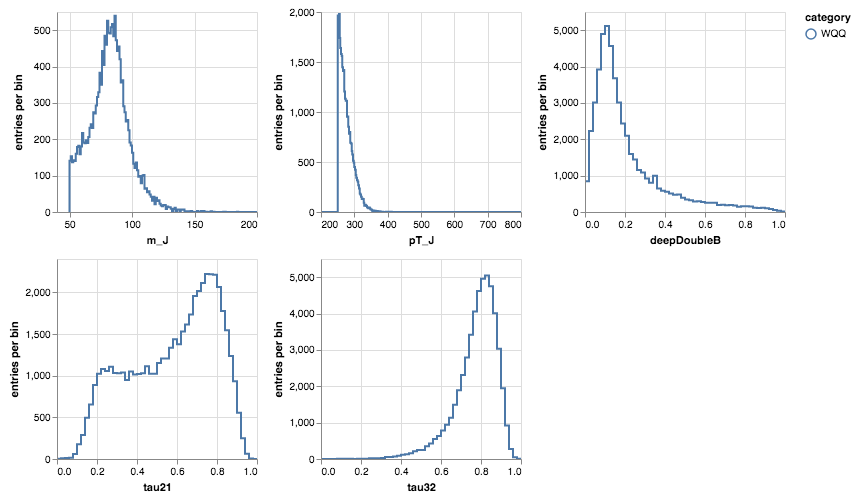

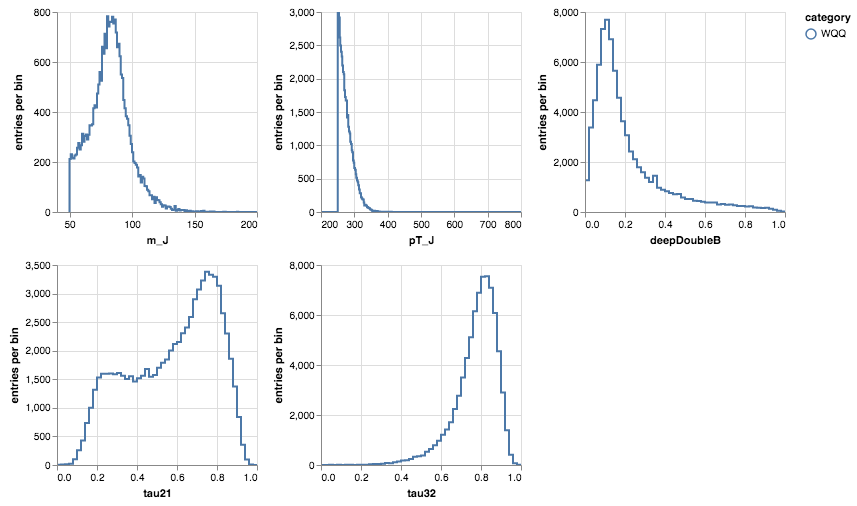

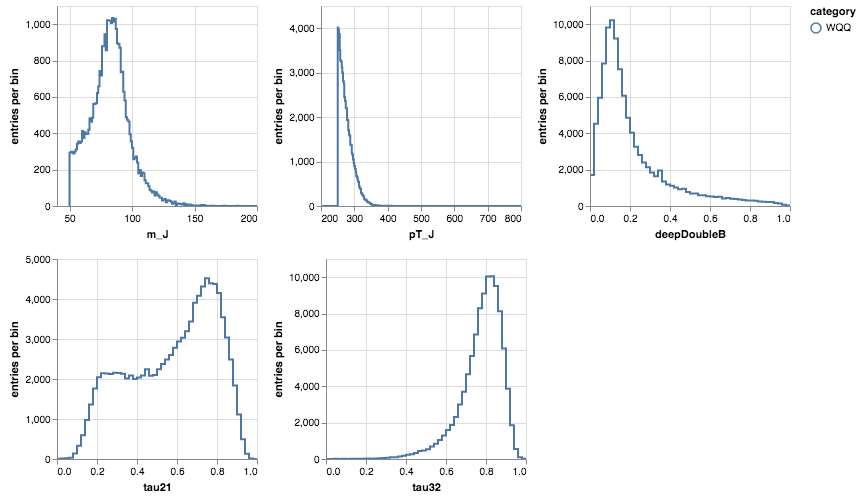

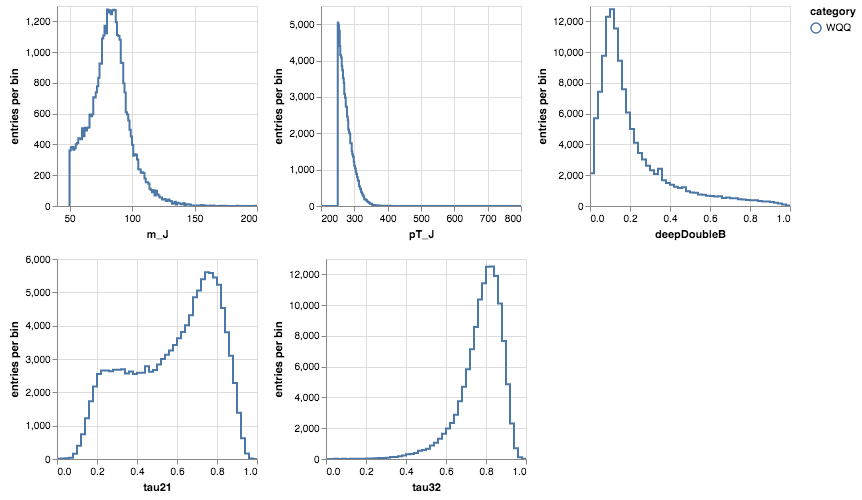

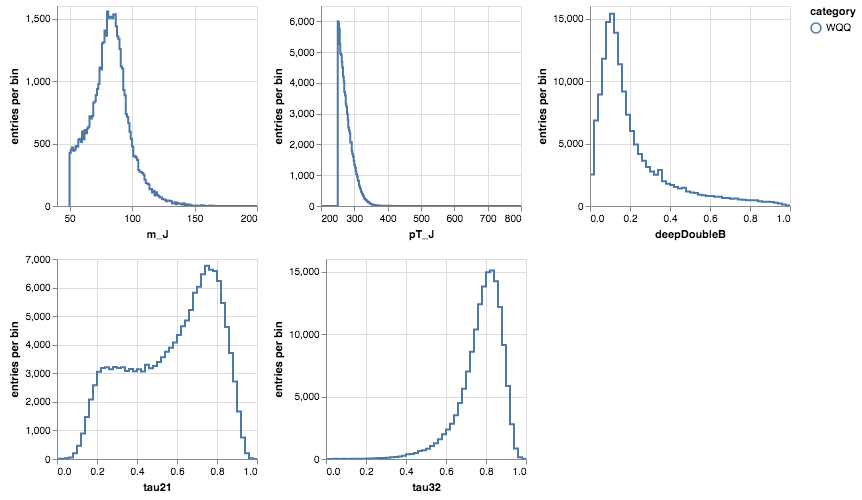

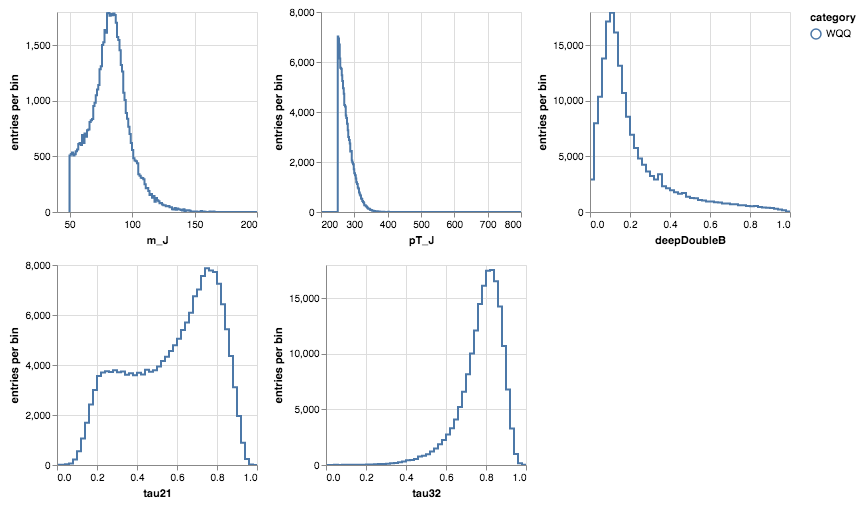

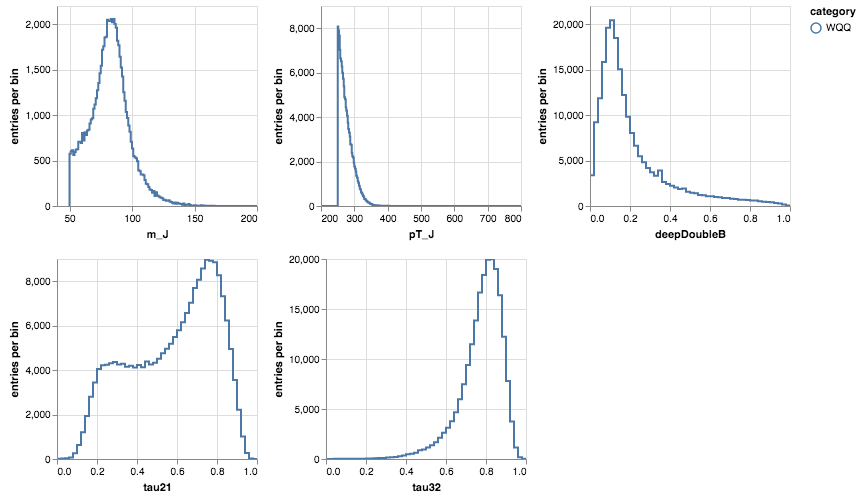

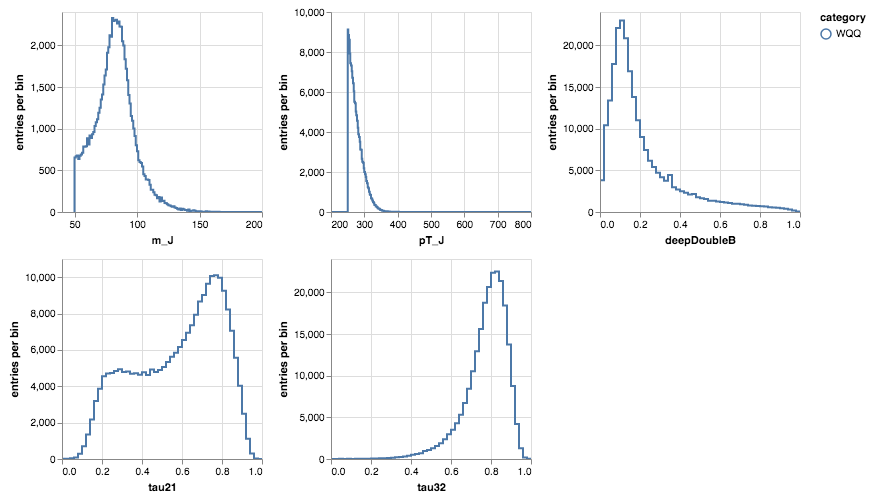

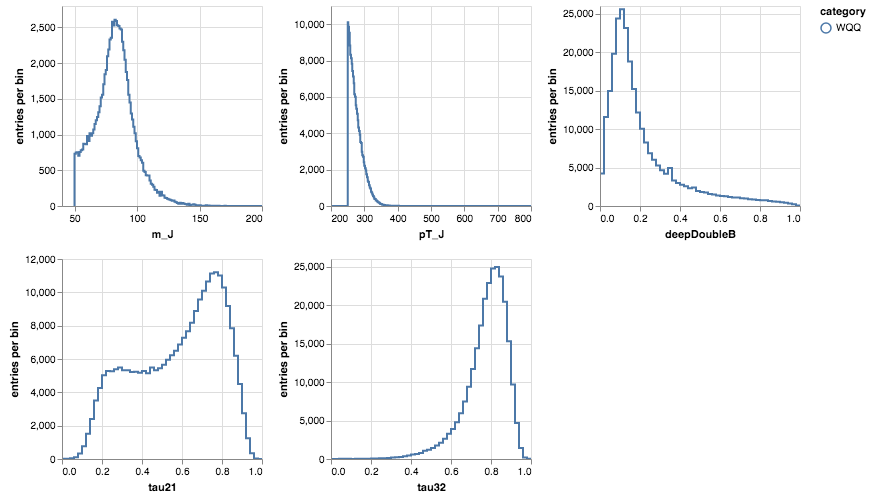

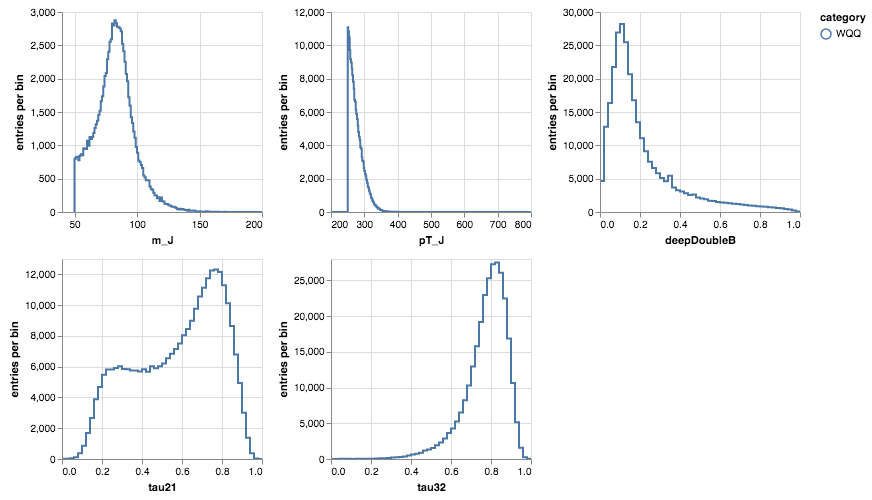

In [ ]:
import concurrent.futures
import multiprocessing
thread_mult = 4
thread_pool = concurrent.futures.ThreadPoolExecutor(thread_mult*multiprocessing.cpu_count())

outer_tic = time.time()

display.init()
_ = map(lambda h: h.clear(), all_hists.values())

filestr = "/Users/lagray/coffea/bacon_prod/WJetsToQQ_HT400to600_qc19_3j_TuneCP5_13TeV/test.root"

evtColumns = {'pfmet':'pfMETC','pfmetphi':'pfMETCphi','puppet':'puppETC','puppetphi':'puppETCphi',
              'npu':'nPUmean','rhoIso':'rhoIso','rhoJet':'rhoJet'}

genPcolumns = {'pt':'GenParticle.pt','eta':'GenParticle.eta','phi':'GenParticle.phi','mass':'GenParticle.mass', 
               'parent':'GenParticle.parent','pdgId':'GenParticle.pdgId','status':'GenParticle.status',                
               'rapidity':'GenParticle.y'}

ak8columns = {'pt':'AK8Puppi.pt','eta':'AK8Puppi.eta','phi':'AK8Puppi.phi','mass':'AK8Puppi.mass',
              'deepcsvb':'AddAK8Puppi.doublecsv','msd':'AddAK8Puppi.mass_sd0','deepdoubleb':'AddAK8Puppi.deepdoubleb',
              'deepdoubleb_nomasssculptpen':'AddAK8Puppi.deepdoubleb_nomasssculptpen','tau1':'AddAK8Puppi.tau1',
              'tau2':'AddAK8Puppi.tau2','tau3':'AddAK8Puppi.tau3','e3_v2_sdb1':'AddAK8Puppi.e3_v2_sdb1',
              'e2_sdb1':'AddAK8Puppi.e2_sdb1',
              'genpt':'AK8Puppi.genpt','geneta':'AK8Puppi.geneta','genphi':'AK8Puppi.genphi',
              'genmass':'AK8Puppi.genm','genmsd':'AK8Puppi.genmsd',
              'neuHadFrac':'AK8Puppi.neuHadFrac','neuEmFrac':'AK8Puppi.neuEmFrac','nParticles':'AK8Puppi.nParticles',
              'muonFrac':'AK8Puppi.muonFrac','chHadFrac':'AK8Puppi.chHadFrac','nCharged':'AK8Puppi.nCharged',
              'chEmFrac':'AK8Puppi.chEmFrac'}

ak4columns = {'pt':'AK4Puppi.pt','eta':'AK4Puppi.eta','phi':'AK4Puppi.phi','mass':'AK4Puppi.mass',
              'qgid':'AK4Puppi.qgid','csv':'AK4Puppi.csv',
              'genpt':'AK4Puppi.genpt','geneta':'AK4Puppi.geneta','genphi':'AK4Puppi.genphi',
              'genmass':'AK4Puppi.genm','genmsd':'AK4Puppi.genmsd',
              'neuHadFrac':'AK4Puppi.neuHadFrac','neuEmFrac':'AK4Puppi.neuEmFrac','nParticles':'AK4Puppi.nParticles',
              'muonFrac':'AK4Puppi.muonFrac','chHadFrac':'AK4Puppi.chHadFrac','nCharged':'AK4Puppi.nCharged',
              'chEmFrac':'AK4Puppi.chEmFrac'}

muoncolumns = {'pt':'Muon.pt','eta':'Muon.eta','phi':'Muon.phi','pogIDBits':'Muon.pogIDBits',
               'chHadIso':'Muon.chHadIso','neuHadIso':'Muon.neuHadIso','gammaIso':'Muon.gammaIso',
               'puIso':'Muon.puIso'}

electroncolumns = {'pt':'Electron.pt','eta':'Electron.eta','phi':'Electron.phi',
                   'typeBits':'Electron.typeBits','chHadIso':'Electron.chHadIso',
                   'neuHadIso':'Electron.neuHadIso','gammaIso':'Electron.gammaIso',
                   'sieie':'Electron.sieie','hovere':'Electron.hovere','eoverp':'Electron.eoverp',
                   'nMissingHits':'Electron.nMissingHits','ecalEnergy':'Electron.ecalEnergy',
                   'dEtaInSeed':'Electron.dEtaInSeed','dPhiIn':'Electron.dPhiIn','d0':'Electron.d0',
                   'trkIso':'Electron.trkIso','hcalDepth1Iso':'Electron.hcalDepth1Iso',
                   'e2x5':'Electron.e2x5','e1x5':'Electron.e1x5','e5x5':'Electron.e5x5',
                   'isConv':'Electron.isConv','scEta':'Electron.scEta'}

taucolumns = {'pt':'Tau.pt','eta':'Tau.eta','phi':'Tau.phi','mass':'Tau.m',
              'hpsDisc':'Tau.hpsDisc','rawIso3Hits':'Tau.rawIso3Hits'}

photoncolumns = {'pt':'Photon.pt','eta':'Photon.eta','phi':'Photon.phi','scEta':'Photon.scEta',
                 'chHadIso':'Photon.chHadIso','neuHadIso':'Photon.neuHadIso','gammaIso':'Photon.gammaIso',
                 'hovere':'Photon.hovere','sieie':'Photon.sieie'}

all_columns = [evtColumns,genPcolumns,ak8columns,ak4columns,
               muoncolumns,electroncolumns,taucolumns,photoncolumns]

columns = []

profiler.start()
for cols in all_columns: columns.extend(list(cols.values()))

print 'extracting',len(columns),'columns'
    
tot_events = 0
tot_time = 0.0
for arrays in uproot.iterate(filestr,'Events',columns,entrysteps=100000,executor=thread_pool):
    tic = time.time()
    #event-level info (run / evt / met / etc)
    eventInfo = JaggedArray.fromcounts(np.ones_like(arrays[evtColumns['pfmet']],dtype=np.int),
                                       Table({key:arrays[val] for key,val in evtColumns.items()}))
    
    #gen particle info (TODO)
    genParticles = JaggedCandidateArray.candidatesfromcounts(arrays[genPcolumns['pt']].counts,
                                                             **{key:arrays[val].content for key,val in genPcolumns.items()})
    
    #k-factors for jets
    #vjetsKF = genParticles.pt.ones_like()
    #genParticles.add_attributes(vjetsKF=vjetsKF)
    
    #setup muon candidates (gotta spoof the mass :-/)
    muonarrays = {key:arrays[val].content for key,val in muoncolumns.items()}
    muonmasses = np.full_like(muonarrays['pt'],0.1056583745)
    muonarrays['mass'] = muonmasses
    muons = JaggedCandidateArray.candidatesfromcounts(arrays[muoncolumns['pt']].counts,
                                                      **muonarrays)
    muons.add_attributes(deltaBetaIso = calcMuonDeltaBetaIso(muons))
    
    #various types of muon we'll need
    passLooseMuonId = passMuonLooseSel(muons)
    looseMuons = muons[passLooseMuonId]
    leadingLooseMuon = looseMuons[looseMuons.pt.argmax()]
    
    passTightMuonId = passMuonTightSel(muons)
    tightMuons = muons[passTightMuonId]
    
    #setup electrons candidates (gotta spoof the mass :-/)
    electronarrays = {key:arrays[val].content for key,val in electroncolumns.items()}
    electronmasses = np.full_like(electronarrays['pt'],0.000511)
    electronarrays['mass'] = electronmasses
    electrons = JaggedCandidateArray.candidatesfromcounts(arrays[electroncolumns['pt']].counts,
                                                          **electronarrays)
    el_abseta = np.abs(electrons.eta)
    electrons.add_attributes(absEta  = el_abseta,
                             EffArea = evaluate['electron_id_EffArea'](el_abseta))
    electrons.add_attributes(effAreaIso = calcElectronEffAreaIso(electrons,eventInfo['rhoIso']))
    
    #various types of electrons we'll need
    passLooseElectronId = passEleLooseSel(electrons)
    looseElectrons = electrons[passLooseElectronId]
    
    #setup tau candidates    
    taus = JaggedCandidateArray.candidatesfromcounts(arrays[taucolumns['pt']].counts,
                                                     **{key:arrays[val].content for key,val in taucolumns.items()})
    #various types of taus we'll need
    passLooseTauId = passTauSel(taus)
    looseTaus = taus[passLooseTauId]
    
    
    #setup photon candidates (gotta spoof the mass :-/)
    photonarrays = {key:arrays[val].content for key,val in photoncolumns.items()}
    photonmasses = np.full_like(photonarrays['pt'],0.0)
    photonarrays['mass'] = photonmasses
    photons = JaggedCandidateArray.candidatesfromcounts(arrays[photoncolumns['pt']].counts,
                                                        **photonarrays)
    ph_absSCeta  = np.abs(photons.scEta)
    EA_CHad = evaluate['photon_id_EA_CHad'](ph_absSCeta)
    EA_NHad = evaluate['photon_id_EA_NHad'](ph_absSCeta)
    EA_Pho  = evaluate['photon_id_EA_Pho'](ph_absSCeta)    
    photons.add_attributes(absSCEta  = ph_absSCeta,
                           EA_CHad = EA_CHad,
                           EA_NHad = EA_NHad,
                           EA_Pho  = EA_Pho)
    photonIsoInfo = calcPhotonEffAreaIso(photons,eventInfo['rhoIso'])
    photons.add_attributes(chIsoCorr  = photonIsoInfo[0],
                           nhIsoCorr  = photonIsoInfo[1],
                           gamIsoCorr = photonIsoInfo[2],
                           neuIsoLooseMax  = photonIsoInfo[3],
                           neuIsoMediumMax  = photonIsoInfo[4],
                           neuIsoTightMax  = photonIsoInfo[5])
        
    #setup ak4 jet candidates
    ak4puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak4columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak4columns.items()})
    ak4_hasbtag = CSV_Medium(ak4puppijet)
    ak4_btags = ak4puppijet[ak4_hasbtag]

    #setup ak8 jet candidates
    ak8puppijet = JaggedCandidateArray.candidatesfromcounts(arrays[ak8columns['pt']].counts,
                                                            **{key:arrays[val].content for key,val in ak8columns.items()})
    msd_corr_8 = ak8puppijet.msd*PUPPIweight(ak8puppijet.pt,ak8puppijet.eta)
    clamped_msd_corr_8 = np.maximum(msd_corr_8,1e-8) #need to bound corrected jet mass from below???
    #need JER/JEC uncertainties up/down added here too!!
    rh_8 = 2.0*(np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt))  # tocheck here
    rhP_8 = 2.0*np.log(clamped_msd_corr_8) - np.log(ak8puppijet.pt)
    jtau21_8 = ak8puppijet.tau2/(ak8puppijet.tau1 + 1e-8)
    jt21P_8 = jtau21_8 + 0.063 * rhP_8
    N2sdb1=ak8puppijet.e3_v2_sdb1/(ak8puppijet.e2_sdb1**2 + 1e-8)
    jtN2b1sdddt_8 = N2sdb1 - evaluate['Rho2D'](rh_8,ak8puppijet.pt)
    #trigger weights for the Vs (TODO: up and down)    
    trigweight = VtrigSF(ak8puppijet.msd,ak8puppijet.pt)
    #store all our calculated stuff
    ak8puppijet.add_attributes(msd_corr_8=msd_corr_8,
                               rh_8=rh_8,
                               rhP_8=rhP_8,
                               tau21=jtau21_8,
                               tau32=ak8puppijet.tau3/(ak8puppijet.tau2 + 1e-8),
                               jt21P_8=jt21P_8,
                               N2sdb1=N2sdb1,
                               jtN2b1sdddt_8=jtN2b1sdddt_8,
                               trigweight=trigweight)
    leadingak8jet = ak8puppijet[ak8puppijet.pt.argmax()]
    
    #todo -> trigger selection
    presel = ( (leadingak8jet.pt > PTCUTMUCR).sum() > 0 # | 
              # AK8Puppijet0_pt_JESUp > PTCUTMUCR | 
              # AK8Puppijet0_pt_JESDown > PTCUTMUCR | 
              # AK8Puppijet0_pt_JERUp > PTCUTMURC |
              # AK8Puppijet0_pt_JERDown > PTCUTMURC 
             )
    #presel = ( ( ak8puppijet.counts > 0 ) & ( ak8puppijet.tau21 < T21DDTCUT) )
    
    #single muon control regions
    #if (jpt_8 > PTCUTMUCR and jmsd_8 > MASSCUT and 
    #    nmuLoose == 1 and neleLoose == 0 and ntau == 0 and vmuoLoose0_pt > MUONPTCUT and 
    #    abs(vmuoLoose0_eta) < 2.1 and isTightVJet and abs(vmuoLoose0_phi - jphi_8) > 2. * ROOT.TMath.Pi() / 3. and 
    #    n_MdR0p8_4 >= 1):
    
    #matching criteria for control regions
    AK8jet_muon_matches = leadingak8jet.argmatch(leadingLooseMuon,argmatchfunc=argMatchByDPhi)    
    AK8jet_AK4bjet_antimatches = leadingak8jet.match(ak4_btags,matchfunc=antiMatchByDR)
    singlemuon_cr = ( #jet selection
                      ((leadingak8jet.pt > PTCUTMUCR).sum() > 0) &
                      ((leadingak8jet.msd_corr_8 > MASSCUT).sum() > 0) &
                      (passJetTightLepVetoSel(leadingak8jet).sum() > 0) &
                      #muon selection
                      ((np.abs(leadingLooseMuon.eta) < 2.1).sum() > 0) &
                      ((leadingLooseMuon.pt > MUONPTCUT).sum() > 0) &
                      #matches and cross cleaning
                      ((AK8jet_muon_matches != -1).counts == 0) &                      
                      (AK8jet_AK4bjet_antimatches.sum() > 0) &
                      #lepton vetos
                      (looseMuons.counts == 1) &
                      (looseElectrons.counts == 0) &
                      (looseTaus.counts == 0)
                    )            
    
    #fill histograms
    all_hists['m_J'].fill(category='WQQ',m_J=ak8puppijet[presel].msd_corr_8.max())
    all_hists['pT_J'].fill(category='WQQ',pT_J=ak8puppijet[presel].pt.max())
    all_hists['deepDoubleB'].fill(category='WQQ',deepDoubleB=ak8puppijet[presel].deepdoubleb.flatten())
    all_hists['tau21'].fill(category='WQQ',tau21=ak8puppijet[presel].tau21.flatten())
    all_hists['tau32'].fill(category='WQQ',tau32=ak8puppijet[presel].tau32.flatten())
    toc = time.time()
    
    tot_time += toc-tic
    tot_events += arrays[evtColumns['pfmet']].size
    display.update()

profiler.stop()
outer_toc = time.time()

In [ ]:
print tot_events
print (outer_toc-outer_tic)/tot_events
print tot_time/tot_events
print 
print(profiler.output_text(unicode=True, color=True))